In [1]:
library(tidyverse)
library(mgsub)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.1     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"程辑包'mgsub'是用R版本4.1.3 来建造的"


# Import data

In [2]:
# read familiarity data
familiarity_raw <- read.csv("../../Study3_CHNvsUSA/output_data/familiarity/familiarity_159rels_usa_2rounds.csv",
                            check.names = FALSE)
familiarity <- colMeans(familiarity_raw[,-1], na.rm = TRUE) %>% as.data.frame()
colnames(familiarity) <- "value"

rel_replace = read.csv('../../../Study2/input_data/Rel_labels/labels_different_versions.csv',
                      row.names=1)
familiarity$'rel_place' = mgsub(rownames(familiarity),
                                rel_replace$'one',rel_replace$'two')
rownames(familiarity) = familiarity$'rel_place'
familiarity = familiarity[-c(2)]

In [3]:
# read distance data
distance_raw <- read.csv("../../../Study2/output_data/group/category/dissim_mla_avg_159rel_all_59p.csv",row.names=1,check.names = FALSE)
distance <- data.frame(relationship1=character(12720),relationship2=character(12720),dissimilarity=numeric(12720))

count = 0
for(i in c(1:159)){
  for(j in c(1:i)){
    count = count+1
    distance$dissimilarity[count] <- distance_raw[i,j]
    distance$relationship1[count] <- rownames(distance_raw[j,])
    distance$relationship2[count] <- rownames(distance_raw[i,])
  }
}

distance <- distance[-which(distance$relationship1 == distance$relationship2),]

# Select relationship

In [4]:
distance <- distance[order(distance$dissimilarity),]
delete_list <- c()

for(i in c(1:nrow(distance))){
   relationship1 <- distance$relationship1[i]
   relationship2 <- distance$relationship2[i]
   if(familiarity[relationship1,] < familiarity[relationship2,]){
     delete_list <- c(delete_list,relationship1)
   }else{
     delete_list <- c(delete_list,relationship2)
   }
}

delete_list <- unique(delete_list)

delete_list <- c(delete_list,setdiff(rownames(familiarity),delete_list))

# Raw data PCA

Helper function

In [5]:
scaleN <- function(data){
  data_scaled <- scale(data)*sqrt(nrow(data)/(nrow(data)-1))  
  return(data_scaled)
}

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}


reOrder <- function(data){
  pc_order <- c()  
  
  #data=a
  pc_order <- c(pc_order,
                getmode(
                  c(which(abs(data['Formality and Regulation',]) == max(abs(data['Formality and Regulation',]))),
                    which(abs(data['Visibility',]) == max(abs(data['Visibility',]))),
                    which(abs(data['Occupational',]) == max(abs(data['Occupational',])))
                    )
                  )
                )
  
  pc_order <- c(pc_order,
                getmode(
                  c(which(abs(data['Importance for individuals',]) == max(abs(data['Importance for individuals',]))),
                    which(abs(data['Activeness',]) == max(abs(data['Activeness',]))),
                    which(abs(data['Spatial Distance',]) == max(abs(data['Spatial Distance',])))
                    )
                  )
                )
  
  pc_order <- c(pc_order,
                getmode(
                  c(which(abs(data['Valence Evaluation',]) == max(abs(data['Valence Evaluation',]))),
                    which(abs(data['Coercion',]) == max(abs(data['Coercion',]))),
                    which(abs(data['Conflict',]) == max(abs(data['Conflict',])))
                    )
                  )
                )
  
  pc_order <- c(pc_order,
                getmode(
                  c(which(abs(data['Goods Exchange',]) == max(abs(data['Goods Exchange',]))),
                    which(abs(data['Concreteness',]) == max(abs(data['Concreteness',]))),
                    which(abs(data['Money Exchange',]) == max(abs(data['Money Exchange',]))),
                    4
                    )
                  )
                )
  
  pc_order <- c(pc_order,setdiff(c(1,2,3,4,5),pc_order))
  
  data_reorder <- data[,pc_order]
  return(data_reorder)
}

In [6]:
raw_data <- t(read.csv('../../Study3_CHNvsUSA/output_data/cleaning_results/USA/USA_combine_dim_rel_30d.csv',
                       row.names=1,check.names = FALSE))
row.names(raw_data) <-  mgsub(row.names(raw_data),
                                rel_replace$'one',rel_replace$'two')

raw_data_scaled <- scaleN(raw_data)

dim_rel.pca = prcomp(raw_data_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp] %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

loadings_var <- reOrder(loadings_var)

# Robustness test

In [7]:
Rel_Num = 154

select_data <- raw_data
robustness_loadings_data <- data.frame(RC1=numeric(Rel_Num),RC2=numeric(Rel_Num),RC3=numeric(Rel_Num),RC4=numeric(Rel_Num),RC5=numeric(Rel_Num))
robustness_scores_data <- data.frame(RC1=numeric(Rel_Num),RC2=numeric(Rel_Num),RC3=numeric(Rel_Num),RC4=numeric(Rel_Num),RC5=numeric(Rel_Num))

raw_scores_var <- scores_var
select_rel <- delete_list


for(i in c(1:Rel_Num)){
  select_data <- select_data[-which(rownames(select_data) %in% delete_list[i]),]
  raw_scores_var <- raw_scores_var[-which(rownames(raw_scores_var) %in% delete_list[i]),]
  select_rel <- select_rel[-1]
  
  select_data_scaled <- scaleN(select_data)

  select_dim_rel.pca = prcomp(select_data_scaled)
  ncomp = 5

  select_loadings_none = select_dim_rel.pca$rotation[,1:ncomp] %*% diag(select_dim_rel.pca$sdev,ncomp,ncomp)
  select_scores_none = select_dim_rel.pca$x[,1:ncomp] 

  select_loadings_var = varimax(select_loadings_none)$loadings
  select_scores_var = scale(select_scores_none) %*% varimax(select_loadings_none)$rotmat
  
  # manually adjust the order after checking the loading results
  if(i != 122){
    select_loadings_var <- reOrder(select_loadings_var)
  }else{
    select_loadings_var <- select_loadings_var[,c(2,1,3,5,4)]
  }
  

  robustness_loadings_data$RC1[i] <- abs(cor.test(loadings_var[,1],select_loadings_var[,1])$estimate)
  robustness_loadings_data$RC2[i] <- abs(cor.test(loadings_var[,2],select_loadings_var[,2])$estimate)
  robustness_loadings_data$RC3[i] <- abs(cor.test(loadings_var[,3],select_loadings_var[,3])$estimate)
  robustness_loadings_data$RC4[i] <- abs(cor.test(loadings_var[,4],select_loadings_var[,4])$estimate)
  robustness_loadings_data$RC5[i] <- abs(cor.test(loadings_var[,5],select_loadings_var[,5])$estimate)
  
  robustness_scores_data$RC1[i] <- abs(cor.test(raw_scores_var[,1],select_scores_var[,1])$estimate)
  robustness_scores_data$RC2[i] <- abs(cor.test(raw_scores_var[,2],select_scores_var[,2])$estimate)
  robustness_scores_data$RC3[i] <- abs(cor.test(raw_scores_var[,3],select_scores_var[,3])$estimate)
  robustness_scores_data$RC4[i] <- abs(cor.test(raw_scores_var[,4],select_scores_var[,4])$estimate)
  robustness_scores_data$RC5[i] <- abs(cor.test(raw_scores_var[,5],select_scores_var[,5])$estimate)
  
  temp <- ''
  for (rel in select_rel){temp = paste(temp,rel,seq=',')}
  
  robustness_loadings_data$rel_list[i] <- temp
}

# Plot results

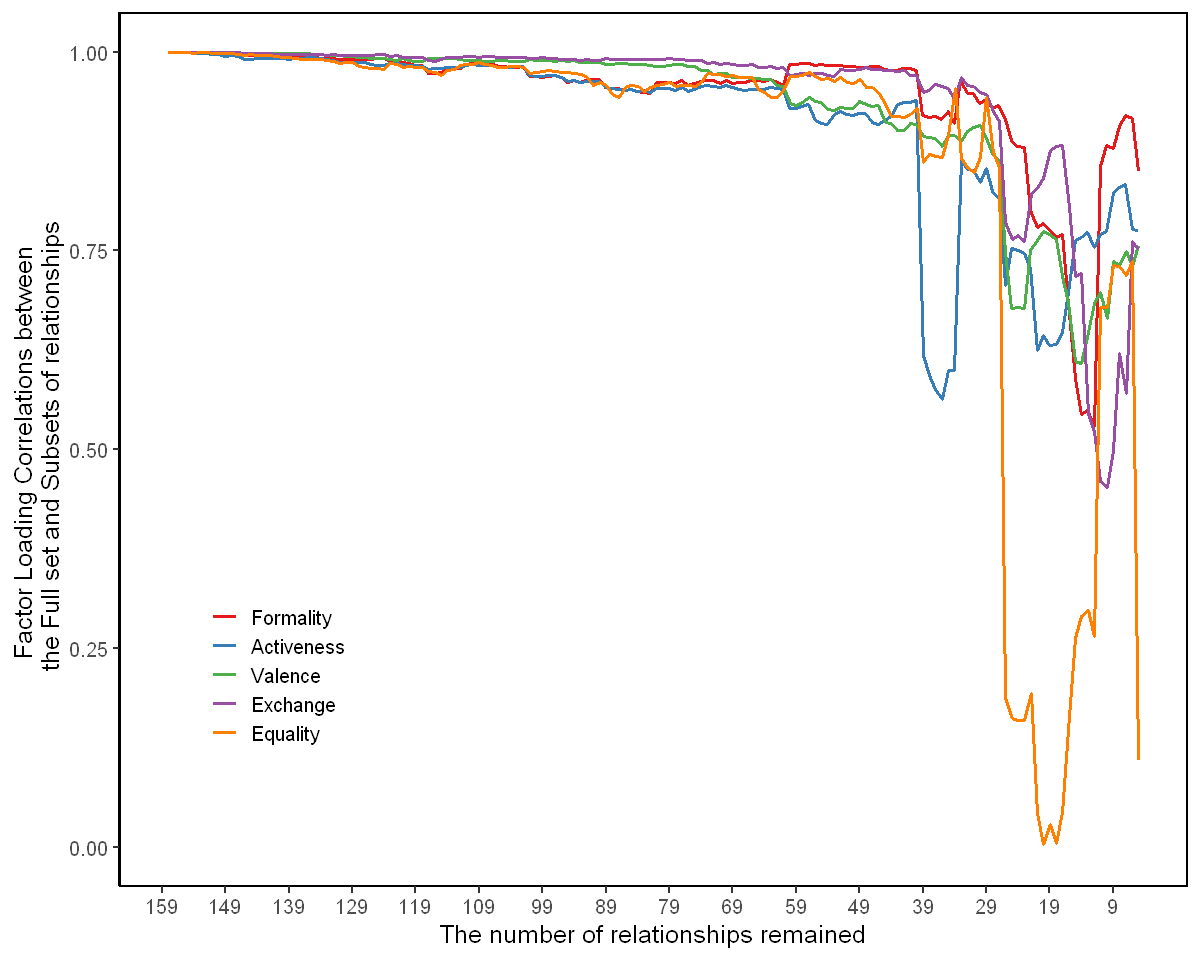

In [8]:
options(repr.plot.width=10,repr.plot.height=8)
robustness_loadings_data$times <- row.names(robustness_loadings_data)
robustness_loadings_data_long <- pivot_longer(robustness_loadings_data,
                                              cols=c(1:5),names_to="RC",values_to = "correlation")
#robustness_loadings_data_long$times <- 159-as.numeric(robustness_loadings_data_long$times)
robustness_loadings_data_long$RC<-factor(robustness_loadings_data_long$RC,
                       levels = c('RC1','RC2','RC3','RC4','RC5'),
                       labels = c("Formality","Activeness","Valence",'Exchange','Equality'))


ggplot(robustness_loadings_data_long,aes(as.numeric(times),correlation,color=RC))+
  #geom_point()+
  geom_line(position = position_dodge(0.1),cex=1)+
  scale_color_brewer(palette = 'Set1')+
  labs(x='The number of relationships remained',y='Factor Loading Correlations between \n the Full set and Subsets of relationships')+
  theme_classic(base_size = 15)+
  theme(legend.position = c(0.15,0.25),
        legend.title = element_blank(),
        legend.background = element_rect(fill = 'transparent'),
        panel.border = element_rect(size = 1,fill = 'transparent'))+
  ylim(0, 1) + 
  scale_x_continuous(breaks=seq(0, 159, 10),labels=seq(159, 0, -10))



write.csv(robustness_loadings_data,"output_data/robustness_loadings_data.csv")